### Classifying Ancient Egyptian Landmarks

Created by Josh Sanchez. Last updated February 1, 2024.

This dataset consists of roughly 3,500 images of Ancient Egyptian landmarks.
The dataset was created by user Marvy Ayman Halim on Kaggle and can be found at: https://www.kaggle.com/datasets/marvyaymanhalim/ancient-egyptian-landmarks-dataset.

In [1]:
# import necessary packages

# data preprocessing
import os
import shutil
import pandas as pd

# data visualization
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# data scaling
from preamble import *
import mglearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# data analysis
from mtcnn import MTCNN
import tensorflow as tf
import keras
from keras import layers
from numpy import asarray
from PIL import Image, ImageOps
import cv2

# Data Preprocessing
Import the data and clean up the folder and file names. Then make the image dataset into a .csv file. 

**Note:** I manually removed the Node.js folder from the dataset because it does not pertain to the project. The original data can be found under the folder called *Data*. The *raw_data* folder contains the original dataset minus the Node.js folder. The *processed_data folder* contains the properly formatted folder and file names.

Only run the following code if processed_data is not already created. This was an early attempt at loading in image data and making it machine readable.

In [2]:
filenames = []
labels = []

# create the processed_data folder
try:
    os.mkdir(os.path.join(os.getcwd(), "processed_data"))
except OSError as error:
    print(error)

processed_data_dir = os.path.join(os.getcwd(), "processed_data")

for folder in os.scandir("raw_data"):
    # if the selected item is not a directory
    if not folder.is_dir():
        continue

    # lowercase the folder name and replace space with underscore
    changed_folder_name = folder.name.lower()
    changed_folder_name = changed_folder_name.replace(" ", "_")

    # add folder to processed_data
    try:
        os.mkdir(os.path.join(processed_data_dir, changed_folder_name))
    except OSError as error:
        print(error)
    processed_folder = os.path.join(processed_data_dir, changed_folder_name)

    # pull filename and store in filenames for dataframe
    for file in os.scandir(folder.path):
        # if the folder is empty
        if len(folder.path) == 0:
            continue
        
        # lowercase the file name and replace space with underscore
        changed_file_name = file.name.lower()
        changed_file_name = changed_file_name.replace(" ", "_")

        # copy the file to its correct folder in processed_data
        shutil.copy(file, processed_folder)

        # rename the file to the edited file name
        raw_file = os.path.join(processed_folder, file.name)                 # the original, unedited file name
        processed_file = os.path.join(processed_folder, changed_file_name)   # the edited file name
        try:
            os.rename(raw_file, processed_file)
        except OSError as error:
            print(error)

        # store properly formatted folder name as a label
        labels.append(changed_folder_name)

        # store filename as a filename
        filenames.append(changed_file_name)

        # create a dataframe by making a tuple of the filename and label
        df = pd.DataFrame(list(zip(filenames, labels)), columns=["image", "label"])

#change the file to a csv
df.to_csv("ancient_egyptian_dataset.csv", index=False)

# Describe the sample and features

In [13]:
df.head(10)

,image,label
0,15634726773_a8ac65d6ef_m_-_copy.jpg,akhenaten
1,19281291360_5a49331215_m.jpg,akhenaten
2,2906415757_50c2bc0414_m.jpg,akhenaten
3,41957529164_421e9f622f_m.jpg,akhenaten
4,4902788942_1c4ee56ede_m.jpg,akhenaten
5,7731634374_fe4e21a493_m.jpg,akhenaten
6,9711457465_051cf60521_n.jpg,akhenaten
7,a.1.jpg,akhenaten
8,a.10.jpg,akhenaten
9,a.11.jpg,akhenaten


# Understanding patterns/trends in the data

In order to understand the data, it must first be described. The code below shows that there are 1337 "unique" images (meaning image filenames) and 22 unique labels. At this point, the model might attempt to cluster the images into 22 distinct groups.

In [ ]:
df.describe()

The below code shows the number of images for each label. This is the number of points expected for each cluster.

In [ ]:
df["label"].value_counts()

# Data transformations
Scale and then grayscale images. Overwrite the image file in processed_data with the transformed images.

In [19]:
batch_size = 32
img_size = 180
for folder in os.scandir(processed_data_dir):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        folder.path,
        labels = 'inferred',
        validation_split = 0.2,
        subset = "training",
        seed = 1,
        image_size = (img_size, img_size),
        batch_size = batch_size)

    val_ds = tf.keras.utils.image_dataset_from_directory(
        folder,
        labels="inferred",
        validation_split=0.2,
        subset="training",
        seed=1,
        image_size=(img_size, img_size),
        batch_size=batch_size,
    )

Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: No images found in directory d:\Data Visualization and Machine Learning\ancient-egyptian-ml-classification\processed_data\akhenaten. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

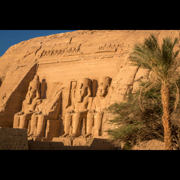

In [33]:
def resize(image_path):
    image = Image.open(image_path)
    size = (180, 180)

    # if the image is already 180 x 180
    if image.size == size:
        return image

    # if the image is already a square
    if image.width == image.height:
        square_img = image.resize(size)
        return square_img

    # if the image's height is smaller than its width
    elif image.width > image.height:
        # pad the image with black bars to get the image to a square size of its width
        square_img = Image.new(image.mode, (image.width, image.width))
        square_img.paste(image, (0, (image.width - image.height) // 2))
        
        # resize the image
        resized_img = square_img.resize(size)
        resized_img.show()
        return resized_img
        # square_img.thumbnail(size)
        # square_img.show()
        # return square_img

    # if the image's width is smaller than 180
    else:
        square_img = Image.new(image.mode, (image.height, image.height))
        square_img.paste(image, ((image.height - image.width) // 2, 0))
        square_img.resize(size)
        print("2", square_img.size)
        return square_img

resize("./processed_data/the_great_temple_of_ramesses_ii/s136.jpg")

In [4]:
def gray_scale(image_path):
    image = Image.open(image_path)
    gray_img = ImageOps.grayscale(image)

    #save image

    
    return gray_img

In [ ]:
def flatten(image_path):
    pass

In [9]:
for image, label in df.values:
    resized = resize(os.path.join(processed_data_dir, label, image))
    gray_img = gray_scale(os.path.join(processed_data_dir, label, image))

resized.show()
# gray_img.show()

orig img size: (135, 240)
new img size: (101, 180)
orig img size: (185, 240)
new img size: (139, 180)
orig img size: (170, 240)
new img size: (127, 180)
orig img size: (149, 240)
new img size: (112, 180)
orig img size: (179, 240)
new img size: (134, 180)
orig img size: (240, 240)
new img size: (180, 180)
orig img size: (320, 196)
new img size: (180, 110)
orig img size: (197, 256)
new img size: (139, 180)
orig img size: (160, 240)
new img size: (120, 180)
orig img size: (180, 240)
new img size: (135, 180)
orig img size: (41, 118)
new img size: (41, 118)
orig img size: (180, 240)
new img size: (135, 180)
orig img size: (180, 240)
new img size: (135, 180)
orig img size: (53, 120)
new img size: (53, 120)
orig img size: (180, 240)
new img size: (135, 180)
orig img size: (180, 240)
new img size: (135, 180)
orig img size: (196, 240)
new img size: (147, 180)
orig img size: (180, 240)
new img size: (135, 180)
orig img size: (180, 240)
new img size: (135, 180)
orig img size: (240, 240)
new img s

## Continuing this project

In order to continue working on the project, the following questions need to be answered:

* Do I need to get my images to be of the same resolution?
* How do I tell the algorithm to cluster into 2 groups, sculpture and structure, in an unsupervised approach?
    * How can it decipher that an image is a structure or sculpture?
* Should the set up of a CNN or pixel boundaries be done in at this step?
* How do I separate my images into a train and test set and at what split?